# Распознавание модели автомобилей на изображениях

## Данные

На данном этапе поддерживаются только 10 моделей автомобилей:
 - Honda Civic
 - Hyundai Accent
 - Hyundai Solaris
 - KIA Cee'd
 - KIA Rio
 - Lada Kalina
 - Mazda 3
 - Nissan Qashqai
 - Opel Astra
 - Toyota Camry
 
Из датасета были отобраны "удачные" фотографии автомобилей. Далее они были обрезаны таким образом, чтобы убрать с фотографии все лишнее. Все полученные изображения имеют пропорции 4x5.

Вспомогательная функция, для отображения галлереи.

In [1]:
import matplotlib.pylab as plt
%matplotlib inline

def plot_gallery(gallery, n_row, n_col, row_labels):
    fig, axes = plt.subplots(nrows=n_row, ncols=n_col, figsize=(1.7 * n_col, 1.7 * n_row))
    
    for plot, img in zip(axes.ravel(), gallery):
        plot.imshow(img, interpolation='nearest')
        plot.set_xticks(())
        plot.set_yticks(())
    
    for ax, label in zip(axes[:, 0], row_labels):
        ax.annotate(label, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - 5, 0),
                    xycoords=ax.yaxis.label, textcoords='offset points',
                    size='large', ha='right', va='center')

    fig.subplots_adjust(left=.15, right=.9, bottom=0, top=0.9, wspace=0.2, hspace=0.35)
    fig.tight_layout()

Отобразим фотографии нескольких автомобилей из каждого класса.

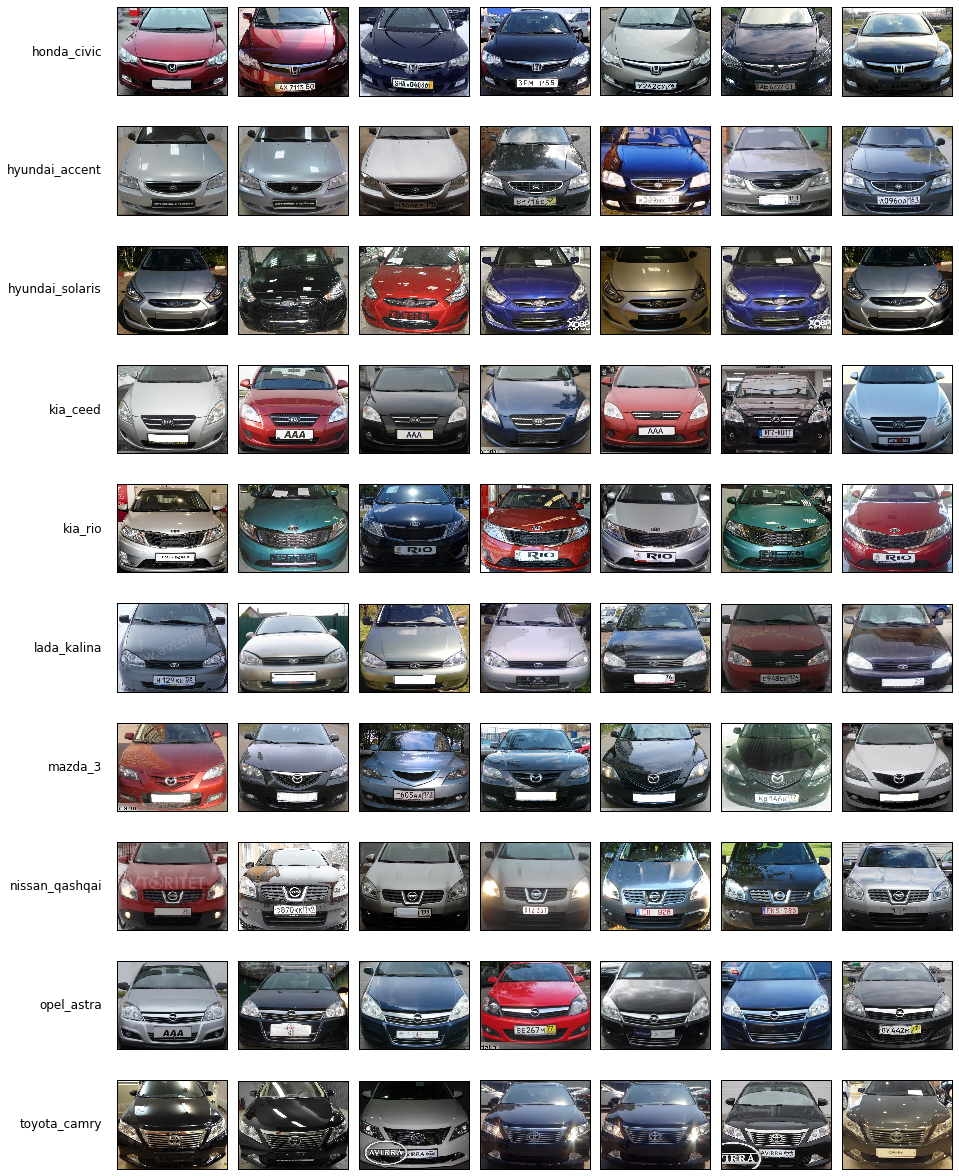

In [2]:
import glob
from itertools import islice
from skimage import io

models = ["honda_civic", "hyundai_accent", "hyundai_solaris", "kia_ceed", "kia_rio",
          "lada_kalina", "mazda_3", "nissan_qashqai", "opel_astra", "toyota_camry"]

gallery = []
for model in models:
    img_paths = glob.iglob("dataset/cropped/{}/*".format(model))
    gallery.extend(io.imread(img_path) for img_path in islice(img_paths, 7))

plot_gallery(gallery, n_row=10, n_col=7, row_labels=models)

## Оценка качества модели

В качестве схемы кросс-валидации используется 5-fold cv, заданная с помощью класса [KFoldCV](http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.KFold.html).

Для оценки качества предсказания классификатора используется наиболее очевидная метрика, а именно доля правильных ответов (accuracy):
$$accuracy = \frac{1}{n} \sum\limits_{i=1}^{n} [\alpha(x_i) = y_i]$$

In [3]:
from sklearn.cross_validation import cross_val_score, KFold

Функция для построения графика с результатами

In [4]:
import matplotlib.pylab as plt
import numpy as np

%matplotlib inline

def plot_quality(grid_scores, param, param_name):
    means = []
    stds = []
    for cv_validation_scores in grid_scores:
        means.append(np.mean(cv_validation_scores))
        stds.append(np.sqrt(np.var(cv_validation_scores)))
    means = np.array(means)
    stds = np.array(stds)

    plt.figure(figsize=(8, 6))
    plt.plot(param, means)
    plt.fill_between(param, means + stds, means - stds, alpha = 0.3, facecolor='blue')
    plt.xlabel(param_name)
    plt.ylabel("Accuracy")

## Представление данных

Для описания фотографий автомобилей мы будем использовать дескриптор, известный под названием [Histogram of Oriented Gradient](http://scikit-image.org/docs/dev/auto_examples/plot_hog.html) (далее просто HOG). Это популярный дескриптор в задачах обнаружения объектов. При помощи него можно отлично описывать объекты, имеющие "жесткую" модель, что как раз подходит для нашей задачи.

Дескриптор имеет несколко параметров. Нас будут интересовать два из них:
- pixels_per_cell - размер (в пикселях) каждой ячеейки
- cells_per_block - число ячеек в каждом блоке

По-умолчанию будем использовать размер ячейки 16x16 и размер блока 2x2, что обеспечит баланс между пространственной поддержкой дескриптора и размером его вектора.

In [5]:
from skimage.feature import hog

## Первая модель - Random Forest

В качестве первой модели будем использовать [RandomForest](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html). Причиной тому является то, что данная модель способна показывать впечатляющие результаты даже без тонкой настройки её параметров. В качестве значения параметра, отвечающего за количество деревьев в лесе (*n_estimators*) выберем достаточно большое число - 300, т.к. данная модель не переобучается с увеличением количества деревьев.

In [6]:
from skimage import transform, io
from sklearn.ensemble import RandomForestClassifier

models = ["honda_civic", "hyundai_accent", "hyundai_solaris", "kia_ceed",
          "kia_rio", "lada_kalina", "mazda_3", "nissan_qashqai",
          "opel_astra", "toyota_camry"]

X, y = [], []

for i, model in enumerate(models):
    for img_name in glob.iglob("dataset/cropped/{}/*".format(model)):
        img = io.imread(fname=img_name, as_grey=True)
        img = transform.resize(image=img, output_shape=(192, 240))
        
        fd = hog(img, pixels_per_cell=(16, 16), cells_per_block=(2, 2))

        X.append(fd)
        y.append(i)

clf = RandomForestClassifier(n_estimators=300, random_state=42)
cv = KFold(len(X), n_folds=5, shuffle=True, random_state=42)
scores = cross_val_score(clf, X, y, scoring="accuracy", cv=cv)
scores.mean()

0.98420327304048238

### Влияние количества моделей автомобилей на точность классификации

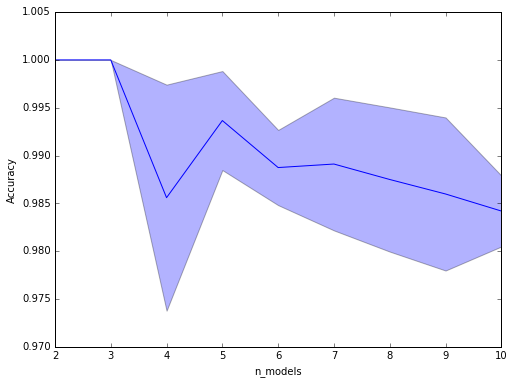

In [7]:
from sklearn.ensemble import RandomForestClassifier

models = ["honda_civic", "hyundai_accent", "hyundai_solaris", "kia_ceed",
          "kia_rio", "lada_kalina", "mazda_3", "nissan_qashqai",
          "opel_astra", "toyota_camry"]

X, y = [], []
grid_scores = []

for i, model in enumerate(models):
    for img_name in glob.iglob("dataset/cropped/{}/*".format(model)):
        img = io.imread(fname=img_name, as_grey=True)
        img = transform.resize(image=img, output_shape=(192, 240))

        fd = hog(img, pixels_per_cell=(16, 16), cells_per_block=(2, 2))

        X.append(fd)
        y.append(i)

    if i > 0:
        clf = RandomForestClassifier(n_estimators=300, random_state=42)
        cv = KFold(len(X), n_folds=5, shuffle=True, random_state=42)
        scores = cross_val_score(clf, X, y, scoring="accuracy", cv=cv)
        grid_scores.append(scores)

plot_quality(grid_scores, range(2, 11), "n_models")

### Подбор гиперпараметров модели

In [ ]:
from sklearn.grid_search import GridSearchCV